In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import warnings; warnings.simplefilter('ignore')
import math
from matplotlib.patches import Circle
import itertools
import numpy.linalg
from IPython.display import clear_output, display
from matplotlib import colors
matplotlib.rc('font',family='Arial')
from matplotlib.lines import Line2D
import os
import math
ppmm = 2.75 
track_directory = "/Users/mrat0010/Documents/GitHub/Polytrack_WIP/data/output/Ratnayake2023_processed_CV4A/Polytrack-raw"

In [11]:

# def calculate_total_distance(df, x_col, y_col):
#     """
#     Calculate the total distance of the track using x and y coordinates from a pandas DataFrame.
    
#     Parameters:
#         df (pd.DataFrame): DataFrame containing x and y coordinates.
#         x_col (str): The name of the column containing x coordinates.
#         y_col (str): The name of the column containing y coordinates.
    
#     Returns:
#         float: The total distance of the track.
#     """
#     # Drop rows where either x or y coordinates are None or NaN
#     df_clean = df.dropna(subset=[x_col, y_col])
    
#     # Calculate the differences between consecutive coordinates
#     dx = df_clean[x_col].diff().dropna()
#     dy = df_clean[y_col].diff().dropna()
    
#     # Calculate the distances between consecutive points
#     distances = np.sqrt(dx**2 + dy**2)
    
#     # Sum the distances to get the total distance
#     total_distance = distances.sum()
    
#     return total_distance

def calculate_total_distance(df, x_col, y_col):
    def calculate_segment_distance(segment):
        distances = np.sqrt(np.diff(segment[x_col])**2 + np.diff(segment[y_col])**2)
        return np.sum(distances)
    
    total_distance = 0
    segment = pd.DataFrame(columns=[x_col, y_col])
    
    for idx, row in df.iterrows():
        if pd.isna(row[x_col]) or pd.isna(row[y_col]):
            if not segment.empty:
                total_distance += calculate_segment_distance(segment)
                segment = pd.DataFrame(columns=[x_col, y_col])
        else:
            segment = pd.concat([segment, pd.DataFrame([row])], ignore_index=True)
    
    if not segment.empty:
        total_distance += calculate_segment_distance(segment)
    
    return total_distance


def filter_and_extract_unique_sequences(df, column_name,min_frames):
    def is_nan(x):
        return math.isnan(x)
    
    # Step 1: Filter out NaN values
    filtered_lst = df[column_name].dropna().tolist()
    
    # Step 2: Extract sequences
    sequences = []
    current_sequence = []
    
    for value in filtered_lst:
        if not current_sequence or value == current_sequence[-1]:
            current_sequence.append(value)
        else:
            if len(current_sequence) >= min_frames:
                sequences.append(current_sequence[0])
            current_sequence = [value]
    
    # Check the last sequence
    if len(current_sequence) >= min_frames:
        sequences.append(current_sequence[0])
    
    # Ensure unique sequences while preserving order
    unique_sequences = []
    for seq in sequences:
        if seq not in unique_sequences:
            unique_sequences.append(seq)
    
    return unique_sequences


def getPlotColor(_insect):
    _insect_type = _insect.split('_')[0]
    # print(_insect_type)
    
    if _insect_type == 'honeybee': _color = '#1f77b4' #blue - honeybee
    elif _insect_type =='hoverfly':_color = '#ff7f0e' #orage - hoverfly
    elif _insect_type == 'moth':_color = '#2ca02c' #green - moth
    elif _insect_type == 'wasp':_color = '#d62728' # red- wasp
    else: _color = '#7f7f7f'
    
    return _color

In [20]:

# Initialize an empty DataFrame
insect_tracks = pd.DataFrame()
# Create the dataframe
track_summary = pd.DataFrame(columns=['insect_num', 'insect_type', 'track_distance', 'flowers_visited'])
insect_info = []
honeybee_tracks = []
hoverfly_tracks = []
moth_tracks = []
wasp_tracks = []

# Walk through all subdirectories in the track_directory
for root, dirs, files in os.walk(track_directory):
    for file in files:
        # Check if the file is a CSV and contains one of the target names
        if file.endswith('.csv') and ('honeybee' in file or 'hoverfly' in file or 'moth' in file or 'wasp' in file):
            # Construct the full filepath
            filepath = os.path.join(root, file)
            # Load the CSV file into a DataFrame
            df = pd.read_csv(filepath)
            

            # Extract the insect name from the filename
            filename = os.path.basename(filepath)
            insect_name = filename.split('_')[6].split('.')[0]
            camera_direction = filename.split('_')[2].split('.')[0]
            insect_number = filename.split('_')[7].split('.')[0]
            insect_info.append((f'{insect_name}_{insect_number}'))

            if insect_name == 'honeybee':
                honeybee_tracks.append(f'{insect_name}_{insect_number}')
            elif insect_name == 'hoverfly':
                hoverfly_tracks.append(f'{insect_name}_{insect_number}')
            elif insect_name == 'moth':
                moth_tracks.append(f'{insect_name}_{insect_number}')
            elif insect_name == 'wasp':
                wasp_tracks.append(f'{insect_name}_{insect_number}')

            # Remove blank spaces in the column names
            df.columns = df.columns.str.strip()


            # If camera_direction is "S", y_adj = 1080 - y, else y_adj=y
            if camera_direction == 'N':
                df['y'] = 1080 - df['y']

            # Convert the x and y columns to mm by dividing by the pixels per mm
            df['x'] = df['x'] / ppmm
            df['y'] = df['y'] / ppmm

            # Smooth out the data in x and y columns using a rolling average
            df['x'] = df['x'].rolling(10, min_periods=1).mean()
            df['y'] = df['y'].rolling(10, min_periods=1).mean()

            total_distance = calculate_total_distance(df, 'x', 'y')
            flowers_visited = filter_and_extract_unique_sequences(df, 'flower', 2)

            insect_data = [insect_number, insect_name, total_distance, len(flowers_visited)]
            track_summary.loc[len(track_summary)] = insect_data
            

            # Rename the columns to include the insect number and insect name
            df.columns = [f'{insect_name}_{insect_number}_{col}' for col in df.columns]

            # add the dataframe to the insect_tracks dataframe
            insect_tracks = pd.concat([insect_tracks, df], axis=1)



insect_tracks

,wasp_4008000309_nframe,wasp_4008000309_x,wasp_4008000309_y,wasp_4008000309_flower,wasp_4006000304_nframe,wasp_4006000304_x,wasp_4006000304_y,wasp_4006000304_flower,wasp_4010000335_nframe,wasp_4010000335_x,...,wasp_4002000832_y,wasp_4002000832_flower,honeybee_1003000940_nframe,honeybee_1003000940_x,honeybee_1003000940_y,honeybee_1003000940_flower,honeybee_1001000030_nframe,honeybee_1001000030_x,honeybee_1001000030_y,honeybee_1001000030_flower
0,5687.0,689.090909,221.090909,NaN,5534.0,528.000000,101.454545,NaN,6471.0,326.545455,...,188.727273,NaN,17411.0,577.818182,357.454545,NaN,926.0,573.818182,387.636364,NaN
1,5688.0,690.181818,227.090909,NaN,5535.0,523.636364,100.181818,NaN,6472.0,327.818182,...,189.454545,NaN,17412.0,577.272727,358.363636,NaN,927.0,573.636364,386.000000,NaN
2,5689.0,690.303030,233.212121,NaN,5536.0,520.121212,98.424242,NaN,6473.0,326.181818,...,168.848485,NaN,17413.0,577.939394,356.000000,NaN,928.0,572.969697,384.363636,NaN
3,5690.0,689.818182,239.000000,NaN,5537.0,520.121212,98.424242,NaN,6474.0,321.454545,...,141.727273,NaN,17414.0,577.939394,356.000000,NaN,929.0,572.272727,381.727273,NaN
4,5691.0,688.000000,243.490909,NaN,5538.0,516.181818,97.454545,NaN,6475.0,318.181818,...,113.527273,NaN,17415.0,584.545455,354.636364,NaN,930.0,571.854545,379.054545,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12399,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Browse through all subdirectories in the track_directory and add csv files containing names flower_positions to a dataframe called flower_positions
position_number_list = []

flower_positions = pd.DataFrame()
for root, dirs, files in os.walk(track_directory):
    for file in files:
        if file.endswith('.csv') and 'flower_positions' in file:
            filepath = os.path.join(root, file)
            filename = os.path.basename(filepath)
            position_number = filename.split('_')[5].split('.')[0]
            position_number_list.append(position_number)

            camera_direction = filename.split('_')[2].split('.')[0]

            df = pd.read_csv(filepath)
            
            # Remove blank spaces in the column names
            df.columns = df.columns.str.strip()

            if camera_direction == 'N':
                df['cy'] = 1080 - df['cy']

            df['cx'] = df['cx'] / ppmm
            df['cy'] = df['cy'] / ppmm
            df['radius'] = df['radius'] / ppmm

            # Rename the columns to include the position number
            df.columns = [f'{position_number}_{col}' for col in df.columns]

            flower_positions = pd.concat([flower_positions, df], axis=1)


flower_positions

,112402_flower_num,112402_species,112402_cx,112402_cy,112402_radius,132804_flower_num,132804_species,132804_cx,132804_cy,132804_radius,...,114802_flower_num,114802_species,114802_cx,114802_cy,114802_radius,123004_flower_num,123004_species,123004_cx,123004_cy,123004_radius
0,0.0,0.0,213.818182,302.909091,10.909091,0.0,0.0,270.909091,76.363636,9.818182,...,0.0,0.0,144.727273,47.636364,9.454545,0.0,0.0,430.545455,291.636364,8.727273
1,1.0,0.0,324.000000,211.636364,8.727273,1.0,0.0,410.909091,348.000000,7.272727,...,1.0,0.0,379.636364,116.727273,8.000000,1.0,0.0,510.909091,241.090909,8.000000
2,2.0,0.0,285.090909,282.181818,6.545455,2.0,0.0,259.272727,97.818182,9.090909,...,2.0,0.0,222.181818,166.545455,8.000000,2.0,0.0,309.090909,277.454545,6.545455
3,3.0,0.0,376.727273,174.909091,8.363636,3.0,0.0,208.000000,245.090909,10.181818,...,3.0,0.0,97.454545,169.454545,7.636364,3.0,0.0,457.818182,323.272727,8.000000
4,4.0,0.0,440.363636,115.636364,7.272727,4.0,0.0,438.181818,319.272727,8.000000,...,4.0,0.0,418.181818,128.727273,8.363636,4.0,0.0,581.454545,335.636364,6.909091
5,NaN,NaN,NaN,NaN,NaN,5.0,0.0,221.090909,139.272727,4.727273,...,5.0,0.0,152.363636,158.909091,8.000000,5.0,0.0,54.909091,81.454545,5.818182
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.0,0.0,121.818182,34.181818,6.909091,6.0,0.0,349.818182,297.818182,5.454545
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.0,0.0,409.818182,148.000000,7.636364,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,0.0,523.272727,293.454545,4.727273,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
track_summary['track_distance'] = track_summary['track_distance'].round(2)
track_summary.head()

# Filter track_summary for honeybees and calculate total flowers visited
honeybee_distance = track_summary[track_summary['insect_type'] == 'honeybee']['track_distance'].sum()

# Filter track_summary for wasps and calculate total flowers visited
wasp_distance = track_summary[track_summary['insect_type'] == 'wasp']['track_distance'].sum()

# Filter track_summary for hoverflies and calculate total flowers visited
hoverfly_distance = track_summary[track_summary['insect_type'] == 'hoverfly']['track_distance'].sum()

# Filter track_summary for moths and calculate total flowers visited
moth_distance = track_summary[track_summary['insect_type'] == 'moth']['track_distance'].sum()

# Print the results
print("Total distance travelled by honeybees:", honeybee_distance)
print("Total distance travelled by wasps:", wasp_distance)
print("Total distance travelled by hoverflies:", hoverfly_distance)
print("Total distance travelled by moths:", moth_distance)

Total distance travelled by honeybees: 16128.880000000001
Total distance travelled by wasps: 2701.4800000000005
Total distance travelled by hoverflies: 1125.71
Total distance travelled by moths: 2062.84


In [23]:


# Filter track_summary for honeybees and calculate total flowers visited
honeybee_flowers_visited = track_summary[track_summary['insect_type'] == 'honeybee']['flowers_visited'].sum()

# Filter track_summary for wasps and calculate total flowers visited
wasp_flowers_visited = track_summary[track_summary['insect_type'] == 'wasp']['flowers_visited'].sum()

# Filter track_summary for hoverflies and calculate total flowers visited
hoverfly_flowers_visited = track_summary[track_summary['insect_type'] == 'hoverfly']['flowers_visited'].sum()

# Filter track_summary for moths and calculate total flowers visited
moth_flowers_visited = track_summary[track_summary['insect_type'] == 'moth']['flowers_visited'].sum()

# Print the results
print("Total flowers visited by honeybees:", honeybee_flowers_visited)
print("Total flowers visited by wasps:", wasp_flowers_visited)
print("Total flowers visited by hoverflies:", hoverfly_flowers_visited)
print("Total flowers visited by moths:", moth_flowers_visited)

Total flowers visited by honeybees: 53
Total flowers visited by wasps: 1
Total flowers visited by hoverflies: 2
Total flowers visited by moths: 8


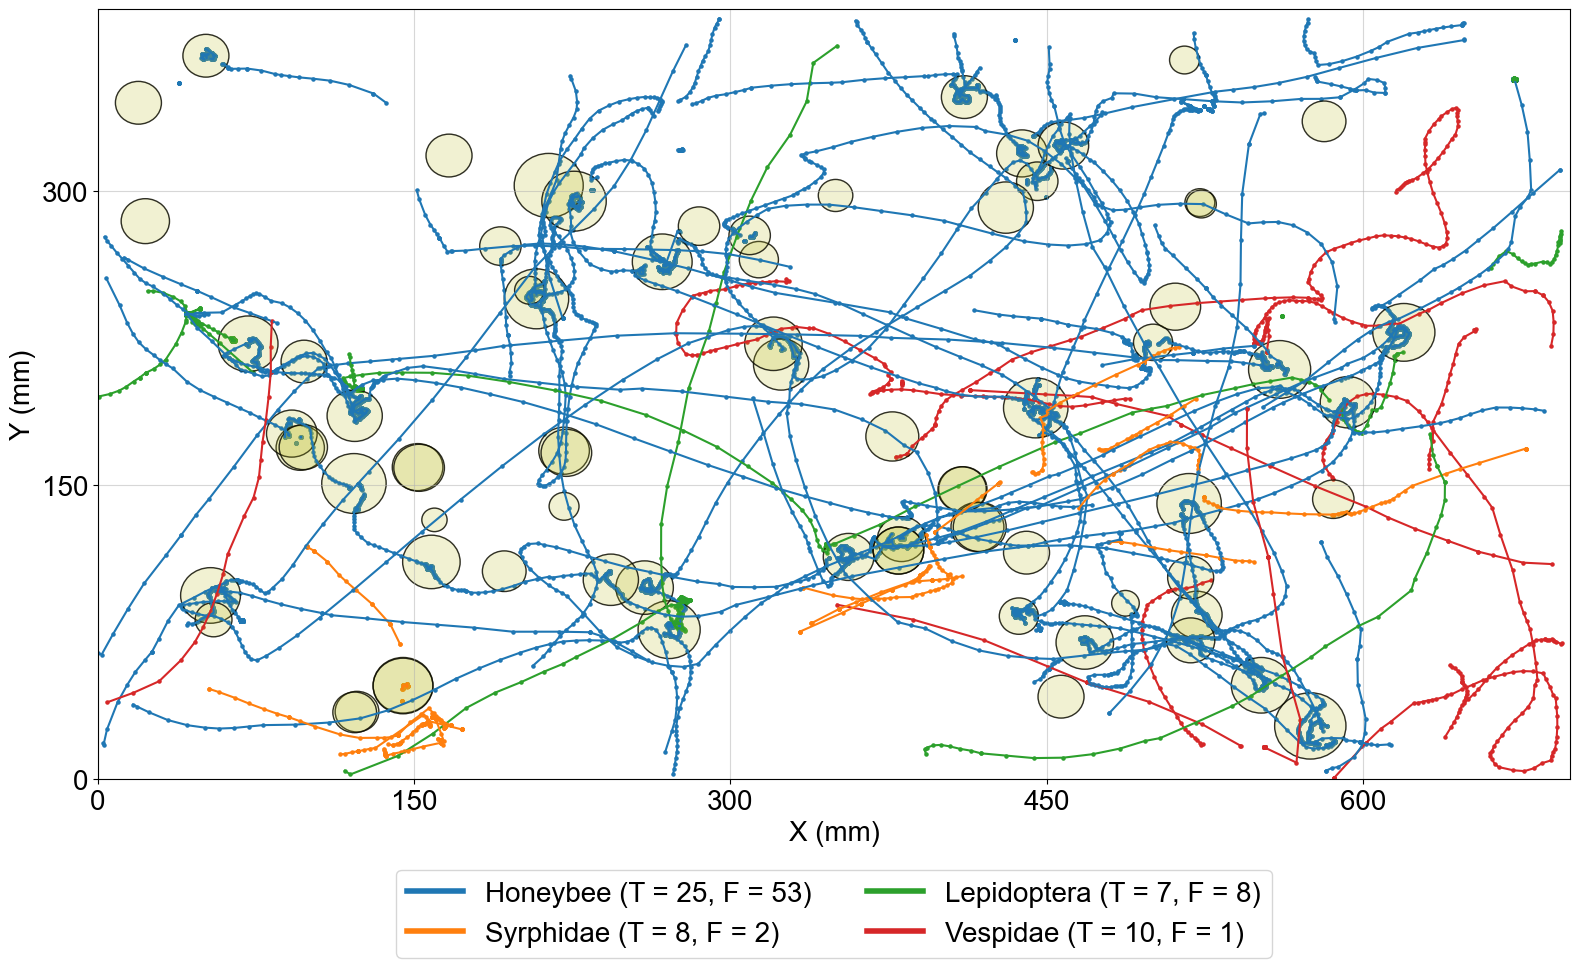

In [36]:
flw_thres = 1.5

plt.figure(figsize=(19,10))

for insect in insect_info:
# insect = insect_info[0]
    x = insect_tracks[f'{insect}_x']
    y = insect_tracks[f'{insect}_y']
    colour = getPlotColor(insect)
    plt.plot(x, y, label=insect, color = colour)
    plt.scatter(x, y, color = colour, s=5)

ax = plt.gca()
for position in position_number_list:
    for row in flower_positions[f'{position}_cx'].dropna().index.tolist():
        ax.add_patch(Circle((flower_positions[f'{position}_cx'][row], flower_positions[f'{position}_cy'][row]), radius = (flower_positions[f'{position}_radius'][row]*flw_thres), color = 'tab:olive', fill=True, alpha = 0.2))
        ax.add_patch(Circle((flower_positions[f'{position}_cx'][row], flower_positions[f'{position}_cy'][row]), radius = (flower_positions[f'{position}_radius'][row]*flw_thres), color = 'k', fill=False, alpha = 0.8))

legend_elements = [Line2D([0], [0], linestyle='-', linewidth= 4, color=getPlotColor('honeybee_'), label='Honeybee (T = '+str(len(honeybee_tracks))+", F = " +str(honeybee_flowers_visited)+")" , markerfacecolor='k', markersize=10),
                     Line2D([0], [0], linestyle='-', linewidth= 4, color=getPlotColor('hoverfly_'), label='Syrphidae (T = '+str(len(hoverfly_tracks))+", F = " +str(hoverfly_flowers_visited)+")", markerfacecolor='k', markersize=10),
                        Line2D([0], [0], linestyle='-', linewidth= 4, color=getPlotColor('moth_'), label='Lepidoptera (T = '+str(len(moth_tracks))+", F = " +str(moth_flowers_visited)+")", markerfacecolor='k', markersize=10),
                            Line2D([0], [0], linestyle='-', linewidth= 4, color=getPlotColor('wasp_'), label='Vespidae (T = '+str(len(wasp_tracks))+", F = " +str(wasp_flowers_visited)+")", markerfacecolor='k', markersize=10)]
                #    Line2D([0], [0], marker="o", color=getPlotColor(11513300101), label='Flowers (T = '+str(flower_count)+")",markerfacecolor='olive', markersize=10, alpha = 0.2)]

# Create the figure
plt.legend(handles=legend_elements, loc=8, ncol=2, frameon=True, fontsize=20, bbox_to_anchor=(0.5, -0.25))

plt.xlabel('X (mm)', fontsize=20)
plt.ylabel('Y (mm)', fontsize=20)
plt.xticks([0, 150, 300, 450, 600],fontsize=20)
plt.yticks([0, 150, 300], fontsize=20)
plt.xlim(0, 1920/ppmm)
plt.ylim(0, 1080/ppmm)
plt.grid(True, alpha = 0.5)

plt.savefig('./figures/raw_tracks.png', dpi=300, bbox_inches='tight')